# Access CMIP6 zarr data from AWS using the osdf protocol and compute GMSTA
- This workflow is inspired by https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html

## Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis) 

## Section 1: Introduction
- Load python packkages
- Load catalog url

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import re
import aiohttp
from dask_jobqueue import PBSCluster
import pandas as pd

/glade/derecho/scratch/harshah/tmp/ipykernel_2781/493514256.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import OSDFFileSystem,PelicanMap 

In [3]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
cat_url     = rda_url +  'harshah/intake_catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'

## Section 2: Select Dask Cluster

#### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [4]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [5]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [6]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [7]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

In [8]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

#### Python logic for a Local Cluster
This uses True/False boolean logic based on the variables set in the previous cells

In [9]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44287 instead
  warnings.warn(


In [10]:
# Scale the cluster and display cluster dashboard URL
cluster.scale(8)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/44287/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.115:40195,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/44287/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Section 3: Data Loading
- Load catalog and select data subset

In [11]:
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [12]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp585',
 'ssp245',
 'ssp370-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp370SST-lowCH4',
 'ssp370SST-lowNTCF',
 'ssp126',
 'ssp119',
 'ssp370',
 'esm-ssp585',
 'ssp245-nat',
 'ssp245-GHG',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-aer',
 'ssp245-stratO3',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

In [13]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp370']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset

,unique
activity_id,2
institution_id,20
source_id,27
experiment_id,3
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,81
dcpp_init_year,0


In [14]:
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id","activity_id"]].nunique()

,experiment_id,variable_id,table_id,activity_id
source_id,,,,
ACCESS-CM2,3,1,1,2
AWI-CM-1-1-MR,3,1,1,2
BCC-CSM2-MR,3,1,1,2
CAMS-CSM1-0,3,1,1,2
CAS-ESM2-0,3,1,1,2
CESM2-WACCM,3,1,1,2
CMCC-CM2-SR5,3,1,1,2
CMCC-ESM2,3,1,1,2
CanESM5,3,1,1,2


In [15]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
3,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20190529
4,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20190529
...,...,...,...,...,...,...,...,...,...,...,...
76,ScenarioMIP,NCC,NorESM2-MM,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
77,ScenarioMIP,NCC,NorESM2-MM,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
78,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20200623
79,ScenarioMIP,AS-RCEC,TaiESM1,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20201014


In [16]:
%%time
dsets_osdf  = col_subset.to_dataset_dict()
print(f"\nDataset dictionary keys:\n {dsets_osdf.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



Dataset dictionary keys:
 dict_keys(['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr', 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp245.Amon.gr', 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp245.Amon.gn', 'CMIP.CAS.CAS-ESM2-0.historical.Amon.gn', 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp370.Amon.gn', 'ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp245.Amon.gn', 'ScenarioMIP.CAS.FGOALS-g3.ssp245.Amon.gn', 'ScenarioMIP.NCC.NorESM2-MM.ssp245.Amon.gn', 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn', 'ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp370.Amon.gn', 'ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp245.Amon.gr1', 'ScenarioMIP.AS-RCEC.TaiESM1.ssp370.Amon.gn', 'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn', 'ScenarioMIP.CMCC.CMCC-ESM2.ssp370.Amon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp370.Amon.gn', 'ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp370.Amon.gn', 'ScenarioMIP.CCCR-IITM.IITM-ESM.ssp245.Amon.gn', 'ScenarioMIP.CCCR-IITM.IITM-ESM.ssp370.Amon.gn', 'ScenarioMI

In [17]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [18]:
dsets_ = dask.compute(dict(dsets))[0]

In [19]:
#calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [20]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean).swap_dims({'time': 'year'})
                             .drop_vars('time').coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',dim=expt_da)

  0%|          | 0/27 [00:00<?, ?it/s]

In [21]:
%%time
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

CPU times: user 10.2 s, sys: 496 ms, total: 10.7 s
Wall time: 1min 13s


In [22]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset> Size: 167kB
Dimensions:        (source_id: 27, experiment_id: 3, year: 251)
Coordinates:
  * year           (year) float64 2kB 1.85e+03 1.851e+03 ... 2.099e+03 2.1e+03
  * experiment_id  (experiment_id) <U10 120B 'historical' 'ssp245' 'ssp370'
  * source_id      (source_id) <U16 2kB 'ACCESS-CM2' ... 'TaiESM1'
Data variables:
    tas            (source_id, experiment_id, year) float64 163kB 287.0 ... 2...

### Observational time series data for comparison with ensemble spread
<!-- obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc" -->

In [23]:
#
osdf_fs = OSDFFileSystem()
print(osdf_fs)


# obs_data = '/gpfs/csfs1/collections/rda/data/harshah/osdf_data/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc'
# ## obs_ds = xr.open_dataset(obs_data)
#
obs_url    = '/ncar/rda/harshah/osdf_data/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc'
#obs_ds = xr.open_dataset(obs_data)
obs_ds = xr.open_dataset(osdf_fs.open(obs_url,mode='rb'),engine='h5netcdf').tas_mean
obs_ds

<xarray.DataArray 'tas_mean' (time: 2101)> Size: 17kB
[2101 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2025-01-1...
    latitude     float64 8B ...
    longitude    float64 8B ...
    realization  int64 8B ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

In [24]:
# obs_url    = 'osdf:///ncar/rda/harshah/osdf_data/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.zarr'
# print(obs_url)
# #
# obs_ds = xr.open_zarr(obs_url).tas_mean
# # obs_ds

In [25]:
# Compute annual mean temperatures anomalies
obs_gmsta = obs_ds.resample(time='YS').mean(dim='time')
obs_gmsta

<xarray.DataArray 'tas_mean' (time: 176)> Size: 1kB
array([-0.41771139, -0.2333498 , -0.22939907, -0.27035444, -0.29152084,
       -0.29691676, -0.32035371, -0.46723004, -0.38876568, -0.28126517,
       -0.39016518, -0.42911293, -0.53636936, -0.34424407, -0.46546508,
       -0.33248133, -0.3412875 , -0.35699412, -0.35182716, -0.31659195,
       -0.32792752, -0.36856275, -0.32811058, -0.3412969 , -0.37325119,
       -0.37562594, -0.42410991, -0.10110884, -0.01131519, -0.30363432,
       -0.31583206, -0.23224553, -0.29553008, -0.34647441, -0.49232007,
       -0.47112358, -0.42090361, -0.49878576, -0.37937889, -0.24989555,
       -0.50685816, -0.40131495, -0.50755854, -0.49461923, -0.48376393,
       -0.44875161, -0.28400727, -0.25980016, -0.48579212, -0.35543365,
       -0.2344939 , -0.29341025, -0.43895654, -0.5332871 , -0.59751106,
       -0.40779323, -0.31910879, -0.5040763 , -0.5138197 , -0.53568716,
       -0.5309095 , -0.53907904, -0.47553864, -0.46701109, -0.26243658,
       -0.19167219, -0.42002315, -0.54281968, -0.4243641 , -0.32528906,
       -0.29835507, -0.24044435, -0.3390137 , -0.31768187, -0.3118017 ,
       -0.28214199, -0.122555  , -0.2291136 , -0.20646581, -0.39244303,
       -0.17680542, -0.10339768, -0.14546171, -0.32234442, -0.17433685,
       -0.20605924, -0.16952095, -0.01919895, -0.01220074, -0.0407972 ,
        0.07593582,  0.0381293 ,  0.00140607,  0.00642158,  0.14410513,
        0.04308835, -0.11881461, -0.09120561, -0.12466127, -0.14380222,
       -0.22662181, -0.06115396,  0.01535455,  0.07763075, -0.11675023,
       -0.19730994, -0.26316562, -0.03533492, -0.01763256, -0.04800481,
       -0.11545958, -0.01999977, -0.06404272, -0.03681061, -0.30586154,
       -0.20442047, -0.14889761, -0.1175393 , -0.16864756, -0.03138624,
       -0.08506409, -0.20588904, -0.09379131,  0.04995016, -0.17252656,
       -0.11075422, -0.2158369 ,  0.1030885 ,  0.00525597,  0.09085814,
        0.19607204,  0.25001204,  0.03426828,  0.22380984,  0.04799352,
        0.04972974,  0.09568698,  0.2430264 ,  0.28215171,  0.17925029,
        0.36058238,  0.33889653,  0.12489684,  0.16570719,  0.23354978,
        0.37686615,  0.27668939,  0.42230852,  0.57734169,  0.32448497,
        0.33108476,  0.48928034,  0.54346649,  0.54417015,  0.46737073,
        0.60686251,  0.57255269,  0.59170132,  0.46564984,  0.59678164,
        0.68037139,  0.53769775,  0.57760705,  0.62357535,  0.67287165,
        0.82511443,  0.93292707,  0.84517425,  0.76265404,  0.89107258,
        0.92292053,  0.76190556,  0.80130532,  1.10031271,  1.18080012,
        1.26334445])
Coordinates:
    latitude     float64 8B ...
    longitude    float64 8B ...
    realization  int64 8B ...
  * time         (time) datetime64[ns] 1kB 1850-01-01 1851-01-01 ... 2025-01-01
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## Section 4: Data Analysis
- Calculate Global Mean Surface Temperature Anomaly (GMSTA)
- Grab some observations/ ERA5 reanalysis data
- Convert xarray datasets to dataframes
- Use Seaborn to plot GMSTA

In [26]:
df_all = big_ds.to_dataframe().reset_index()
df_all.head()

,source_id,experiment_id,year,tas
0,ACCESS-CM2,historical,1850.0,287.007494
1,ACCESS-CM2,historical,1851.0,287.016985
2,ACCESS-CM2,historical,1852.0,287.174542
3,ACCESS-CM2,historical,1853.0,287.070948
4,ACCESS-CM2,historical,1854.0,287.141159


In [27]:
# Compute anomaly w.r.t 1960-1990 baseline
# Define the baseline period
baseline_df = df_all[(df_all["year"] >= 1960) & (df_all["year"] <= 1990)]

# Compute the baseline mean
baseline_mean = baseline_df["tas"].mean()

# Compute anomalies
df_all["tas_anomaly"] = df_all["tas"] - baseline_mean
df_all

,source_id,experiment_id,year,tas,tas_anomaly
0,ACCESS-CM2,historical,1850.0,287.007494,-0.231968
1,ACCESS-CM2,historical,1851.0,287.016985,-0.222477
2,ACCESS-CM2,historical,1852.0,287.174542,-0.064920
3,ACCESS-CM2,historical,1853.0,287.070948,-0.168514
4,ACCESS-CM2,historical,1854.0,287.141159,-0.098303
...,...,...,...,...,...
20326,TaiESM1,ssp370,2096.0,291.798424,4.558962
20327,TaiESM1,ssp370,2097.0,291.854096,4.614635
20328,TaiESM1,ssp370,2098.0,292.141126,4.901665
20329,TaiESM1,ssp370,2099.0,292.206289,4.966827


In [28]:
obs_df = obs_gmsta.to_dataframe(name='tas_anomaly').reset_index()
# obs_df

In [29]:
# Convert 'time' to 'year' (keeping only the year)
obs_df['year'] = obs_df['time'].dt.year

# Drop the original 'time' column since we extracted 'year'
obs_df = obs_df[['year', 'tas_anomaly']]
obs_df

,year,tas_anomaly
0,1850,-0.417711
1,1851,-0.233350
2,1852,-0.229399
3,1853,-0.270354
4,1854,-0.291521
...,...,...
171,2021,0.761906
172,2022,0.801305
173,2023,1.100313
174,2024,1.180800


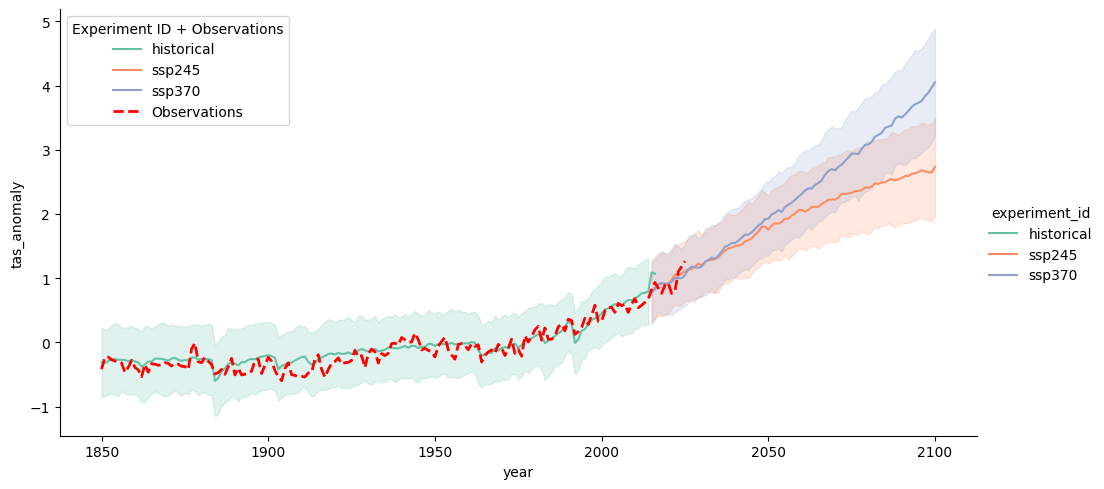

In [30]:
# Create the main plot
g = sns.relplot(data=df_all, x="year", y="tas_anomaly",
                hue='experiment_id', kind="line", errorbar="sd", aspect=2, palette="Set2")  # Adjust the color palette)

# Get the current axis from the FacetGrid
ax = g.ax

# Overlay the observational data in red
sns.lineplot(data=obs_df, x="year", y="tas_anomaly",color="red", 
             linestyle="dashed", linewidth=2,label="Observations", ax=ax)

# Adjust the legend to include observations
ax.legend(title="Experiment ID + Observations")

# Show the plot
plt.show()

In [31]:
cluster.close()

In [32]:
# sns.relplot(data=df_all,x="year", y="tas_anomaly", hue='experiment_id',kind="line", errorbar="sd", aspect=2)